In [2]:
%reload_ext autoreload
%autoreload 1
%matplotlib inline 

import os
import glob
import numpy as np
import pdb
from astropy.io import fits
from astropy.io import ascii
from astropy.wcs import WCS
import astropy.stats
from astropy.visualization import make_lupton_rgb
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip
from astropy import convolution
from astropy.time import Time
from astropy.coordinates import EarthLocation
from astropy.coordinates import SkyCoord
from astroplan.plots import plot_airmass, plot_altitude
from astroplan import Observer
import astroplan
from scipy import interpolate
from scipy import optimize
from scipy import stats
from scipy import ndimage
from scipy import special
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib
from tqdm import tqdm
from IPython.core.debugger import set_trace
import importlib
import matplotlib.patches as mpatches
import matplotlib
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import ConnectionPatch, Circle
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import pickle
from PyAstronomy import pyasl
import sys
from reproject import reproject_interp
import pyregion
import emcee
import corner

from scipy.io import readsav

import cmcrameri as SCM7

import pyneb as pn
#import aplpy

import cwitools
from cwitools import reduction
from cwitools import coordinates

from photutils.aperture import CircularAperture
from photutils.aperture import SkyCircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.background import Background2D, MedianBackground


from astropy import cosmology
cosmo=cosmology.FlatLambdaCDM(70,0.3)

font = {'family' : 'DejaVu Sans',
        'size'   : 15}

matplotlib.rc('font', **font)

In [3]:
hdl = fits.open('/Volumes/obs-data/obs/2024feb11/kred_test/redux/kskywizard/kr240211_00095_invsens_updated.fits')

hdl.info()

Filename: /Volumes/obs-data/obs/2024feb11/kred_test/redux/kskywizard/kr240211_00095_invsens_updated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     682   (3324, 6)   float64   


In [4]:
hdl[0].data

array([[3.32970074e-17, 3.35648915e-17, 3.29009931e-17, ...,
        4.15856037e-18, 5.69606372e-18, 1.31693763e-17],
       [1.63778105e-17, 1.63489634e-17, 1.63202222e-17, ...,
        4.92077091e-18, 4.91720369e-18, 4.91362613e-18],
       [1.59126782e+03, 1.57850549e+03, 1.61028271e+03, ...,
        2.40044751e+03, 1.75225427e+03, 7.57770874e+02],
       [1.64806919e-17, 1.64480332e-17, 1.64155302e-17, ...,
        5.21229773e-18, 5.21655399e-18, 5.22090265e-18],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.97913834e-01, 8.74097726e-01, ...,
        8.29983071e-01, 7.76360374e-01, 0.00000000e+00]])

In [6]:
hdr = hdl[0].header

wave = (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1) * hdr['CDELT1'] + hdr['CRVAL1']


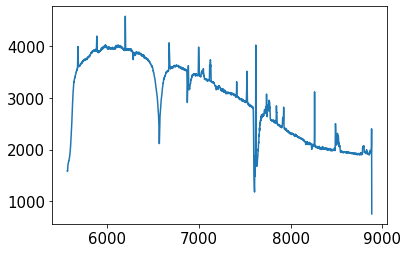

In [9]:
plt.plot(wave, hdl[0].data[2])

In [10]:
from astropy import io

listfile = '/Volumes/obs-data/obs/2024feb11/kred_test/redux/kskywizard/arcs_test.list'

# read the list
listtab = io.ascii.read(listfile, format='no_header', comment='\s*#')

1.07
1.07
1.07
1.07
1.07


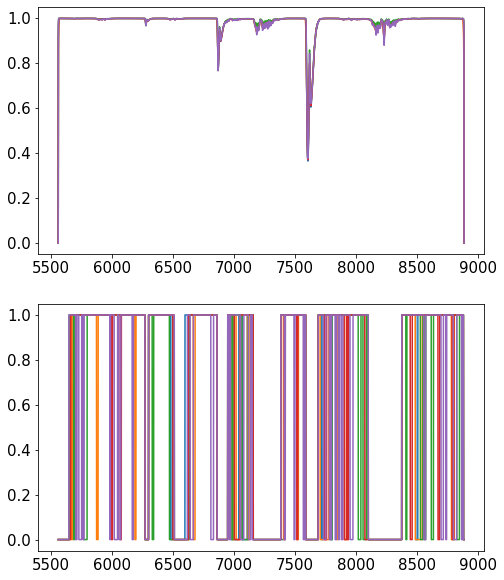

In [19]:
from scipy.interpolate import interp1d

fig, axes = plt.subplots(2, 1, figsize=(8, 10))

for i, invsensfn in enumerate(listtab['col1']):

    if (i==0) and ('updated' in invsensfn):
        telluric_flag = True
    
    # read file
    hdu = fits.open(invsensfn)[0]
    data = hdu.data
    hdr= hdu.header

    # save the first file
    if i==0:
        data0 = data.copy()
        hdr0 = hdr.copy()

    print(hdr['AIRMASS'])
    # check instrument setup
    ifunam = hdr['IFUNAM']
    gratnam = hdr['BGRATNAM']
    cwave = np.round(hdr['BCWAVE'])
    pwave = np.round(hdr['BPWAVE'])
    if i==0:
        ifunam0 = ifunam
        gratnam0 = gratnam
        cwave0 = cwave
        pwave0 = pwave

    if ifunam!=ifunam0 or gratnam!=gratnam0 or cwave!=cwave0 or pwave!=pwave0:
        print(': [Warning] Inconsistent instrument config:')
        print('   0 - IFU = {}, GRAT = {}, CWAVE = {}, PWAVE = {}'.format(ifunam0, gratnam0, cwave0, pwave0))
        print('  ' + invsensfn + ' - IFU = {}, GRAT = {}, CWAVE = {}, PWAVE = {}'.format(\
                ifunam, gratnam, cwave, pwave))

    # Check wavelength
    wave = (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1) * hdr['CDELT1'] + hdr['CRVAL1']
    dw = wave[1] - wave[0]
    if i==0:
        wave0 = wave
        dw0 = dw

    # resample
    if wave0[0]!=wave[0] or dw0!=dw or len(wave0)!=len(wave):
        li = interp1d(wave, data[0, :], kind='linear', bounds_error=False, fill_value='extrapolate')
        invsens_0 = li(wave0)
        li = interp1d(wave, data[1, :], kind='linear', bounds_error=False, fill_value='extrapolate')
        invsens_1 = li(wave0)
    else:
        invsens_0 = data[5, :]
        invsens_1 = data[4, :]
    
    axes[0].plot(wave0, invsens_0)
    axes[1].plot(wave0, invsens_1)
    